## Arellano Economy with Three States

In the summary we specify the model. The main difference is that we decompose the income process between a systemic component $\Delta_{t}$ and an idiosyncratic component $\epsilon_{it}$. We assume the processes are independent, so we can create two independent Tauchen processes, obtain their marginal Markov transition matrix and then just compite the kroenecker product for the joint Markov matrix.

First define the ArellanoEconomy type which will contain all the parameters that define this economy.
Note that since we are parallelizing, we have to define the ArellanoModel type everywhere. The parallelization will be done in the outer loop (nodes on output) and each worker will find the point in the grid in next period's bonds that maximizes the value function. This is the same maximization algorithm as in the original Arellano code from QuantEcon.

Since each worker will be inside the `one_step_update!` function, we do not have to set everywhere the `HIS!` and `VFI!` and `compute_prices!` functions.

In [1]:
addprocs(4)

using QuantEcon, Distributions

@everywhere begin

    using QuantEcon
    
    abstract ArellanoModel

    immutable ArellanoEconomy <: ArellanoModel
        # Model Parameters
        β::Float64
        γ::Float64
        r::Float64
        ρΔ::Float64
        ρϵ::Float64
        ηΔ::Float64
        ηϵ::Float64
        θ::Float64

        # Grid Parameters
        nΔ::Int64
        nϵ::Int64
        nB::Int64
        ns::Int64
        Δgrid::Array{Float64, 1}
        ϵgrid::Array{Float64, 1}
        sgrid::Array{Float64, 2} # Will contain the pair (Δ,ϵit) that give value for y
        ygrid::Array{Float64, 1}
        ydefgrid::Array{Float64, 1}
        Bgrid::Array{Float64, 1}
        ΠΔ::Array{Float64, 2}
        Πϵ::Array{Float64, 2}
        Π::Array{Float64, 2}

        # Value function
        vf::Array{Float64, 2}
        vd::Array{Float64, 2}
        vc::Array{Float64, 2}
        policy::Array{Int64, 2}
        q::Array{Float64, 2}
        defprob::Array{Float64, 2}
    end
    
    u(ae::ArellanoEconomy, c) = c^(1 - ae.γ) / (1 - ae.γ)
    
    function one_step_update!(ae::ArellanoEconomy, EV::Matrix{Float64},
                          EVd::Matrix{Float64}, EVc::Matrix{Float64})

        zero_ind = searchsortedfirst(ae.Bgrid, 0.)
        
        VC = SharedArray(Float64,size(ae.vc))
        PL = SharedArray(Float64,size(ae.policy))
        VF = SharedArray(Float64,size(ae.vf))
        VD = SharedArray(Float64,size(ae.vd))

        @sync @parallel for is=1:ae.ns
            y = ae.ygrid[is]
            ydef = ae.ydefgrid[is]

            # Value of being in default with income y
            defval = u(ae, ydef) + ae.β*(ae.θ*EVc[zero_ind, is] + (1-ae.θ)*EVd[1, is])
            VD[1, is] = defval

           for ib=1:ae.nB
                B = ae.Bgrid[ib]

                current_max = -1e14
                pol_ind = 0
                for ib_next=1:ae.nB
                    c = max(y - ae.q[ib_next, is]*ae.Bgrid[ib_next] + B, 1e-14)
                    m = u(ae, c) + ae.β * EV[ib_next, is]

                    if m > current_max
                        current_max = m
                        pol_ind = ib_next
                    end

                end

                # Update value and policy functions
                VC[ib, is] = current_max
                PL[ib, is] = pol_ind
                VF[ib, is] = defval > current_max ? defval: current_max
            end
            
        end
        
        copy!(ae.vc,VC)
        copy!(ae.policy,PL)
        copy!(ae.vf,VF)
        copy!(ae.vd,VD)

        Void
    end
end

As in the HIS version of the two-state Arellano, we now define the HIS and VFI functions. The HIS is to increase speed, as already stated.

In [2]:
function HIS!(ae::ArellanoEconomy, H)
    
    Πt = ae.Π'
    
    Vh_upd = zeros(ae.vf)
    
    zero_ind = searchsortedfirst(ae.Bgrid, 0.)
    
    ith = 0
    
    for hh=1:H
        
        ith+=1
        
        copy!(Vh_upd,ae.vf)
        
        EV  = ae.vf * Πt
        EVd = ae.vd * Πt
        EVc = ae.vc * Πt
        
        for is=1:ae.ns
            y = ae.ygrid[is]
            ydef = ae.ydefgrid[is]

            # Value of being in default with income y
            defval = u(ae, ydef) + ae.β*(ae.θ*EVc[zero_ind, is] + (1-ae.θ)*EVd[1, is])
            ae.vd[1, is] = defval

            for ib=1:ae.nB
                B = ae.Bgrid[ib]
                ib_next = ae.policy[ib,is]
                
                c = max(y - ae.q[ib_next, is]*ae.Bgrid[ib_next] + B, 1e-14)
                ae.vc[ib,is] = u(ae, c) + ae.β * EV[ib_next, is]
                ae.vf[ib,is] = defval > ae.vc[ib,is] ? defval: ae.vc[ib,is]
                end
            end
        dist_h = maxabs(Vh_upd - ae.vf)
        
#         if ith%100 == 0
#             println("Finished HIS iteration $(ith) with dist of $(dist_h)")
#         end
    end
end

function compute_prices!(ae::ArellanoEconomy)

    # Create default values with a matching size
    vd_compat = repmat(ae.vd, ae.nB)
    default_states = vd_compat .> ae.vc

    # Update default probabilities and prices
    copy!(ae.defprob, default_states * ae.Π')
    copy!(ae.q, (1 - ae.defprob) / (1 + ae.r))

    Void
end

function vfi!(ae::ArellanoEconomy; tol=1e-8, maxit=10000)

    Πt = ae.Π'

    # Iteration stuff
    it = 0
    dist = 10.

    # Allocate memory for update
    V_upd = zeros(ae.vf)

    while dist > tol && it < maxit
        it += 1
        
        if dist>1e-4

            # Compute expectations for this iterations
            # (We need Π' because of order value function dimensions)
            copy!(V_upd, ae.vf)
            EV  = ae.vf * Πt
            EVd = ae.vd * Πt
            EVc = ae.vc * Πt

            # Update Value Function
            one_step_update!(ae, EV, EVd, EVc)

            # Update prices
            compute_prices!(ae)
            
        else
            copy!(V_upd, ae.vf)
            
            # Howard Iterative Step
            H = 2*it
            HIS!(ae, H)
            
            EV  = ae.vf * Πt
            EVd = ae.vd * Πt
            EVc = ae.vc * Πt
            
            # Update Value Function
            one_step_update!(ae, EV, EVd, EVc)
            
            # Update prices
            compute_prices!(ae)
        end

        dist = maxabs(V_upd - ae.vf)

        if it%50 == 0
            println("Finished iteration $(it) with dist of $(dist)")
        end
    end

    println("Finished procedure with $(it) iterations and with dist of $(dist)")
    
    Void
end


vfi! (generic function with 1 method)

In [3]:
    function ArellanoEconomy(;β=.953, γ=2., r=0.017, ρΔ=0.85, ρϵ=0.7, ηΔ=0.007, ηϵ=0.018, θ=0.282,
        nΔ=12, nϵ=12, nB=800, ns=nΔ*nϵ)

        # Create grids
        Bgrid = collect(linspace(-.4, .4, nB))
        res_markΔ = tauchen(nΔ, ρΔ, ηΔ)
        res_markϵ = tauchen(nϵ, ρϵ, ηϵ)
        ΠΔ = res_markΔ.p
        Πϵ = res_markϵ.p
        Π  = kron(ΠΔ,Πϵ)
        Δgrid = collect(res_markΔ.state_values)
        ϵgrid = collect(res_markϵ.state_values)

        sgrid = [kron(Δgrid,ones(nϵ)) kron(ones(nΔ),ϵgrid)]
        ygrid = exp(sgrid[:,1]+sgrid[:,2])
        ydefgrid = min(.969 * mean(ygrid), ygrid)

        # Define value functions (Notice ordered different than Python to take
        # advantage of column major layout of Julia)
        vf = zeros(nB, ns)
        vd = zeros(1, ns)
        vc = zeros(nB, ns)
        policy = Array(Int64, nB, ns)
        q = ones(nB, ns) .* (1 / (1 + r))
        defprob = Array(Float64, nB, ns)

        return ArellanoEconomy(β, γ, r, ρΔ, ρϵ, ηΔ, ηϵ, θ, nΔ, nϵ, nB, ns, Δgrid, ϵgrid, sgrid, ygrid,
        ydefgrid, Bgrid, ΠΔ, Πϵ, Π, vf, vd, vc, policy, q, defprob)
    end

ArellanoEconomy

Write down the code for simulation.

In what follows the code runs the model and gives several figures.

In [4]:
ae = ArellanoEconomy(ρΔ=0.85, ρϵ=0.7, ηΔ=0.007, ηϵ=0.018, nΔ=10, nϵ=10, nB=400)

# now solve the model on the grid. 
@time vfi!(ae)

Finished iteration 50 with dist of 0.09652614706901375
Finished iteration 100 with dist of 0.008695255746729913
Finished iteration 150 with dist of 0.000783298671507282
Finished procedure with 195 iterations and with dist of 7.176481631177012e-13
 33.349373 seconds (9.33 M allocations: 1.328 GB, 0.77% gc time)


Void

/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is bui

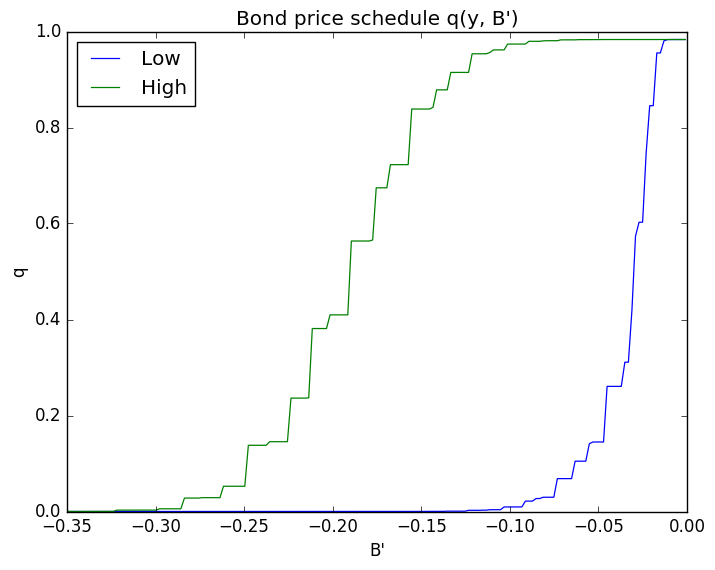

PyObject <matplotlib.text.Text object at 0x3225e0810>

In [5]:
using PyPlot, Compose, ColorTypes, DataFrames

# Create "Y High" and "Y Low" values as 5% devs from mean
high, low = mean(ae.ygrid)*1.05, mean(ae.ygrid)*.95



iy_high, iy_low = map(x-> findmin(abs(ae.ygrid - x))[2], (high, low))

# Δ_high, ϵ_high = ae.sgrid[iy_high,1], ae.sgrid[iy_high,2]

# Extract a suitable plot grid
x = Float64[]
q_low = Float64[]
q_high = Float64[]
for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.35 <= b <= 0  # To match fig 3 of Arellano
        push!(x, b)
        push!(q_low, ae.q[i, iy_low])
        push!(q_high, ae.q[i, iy_high])
    end
end

str = ["Low","High"]
vals_plot = [q_low q_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](x,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Bond price schedule q(y, B')")
xlabel("B'"); ylabel("q")

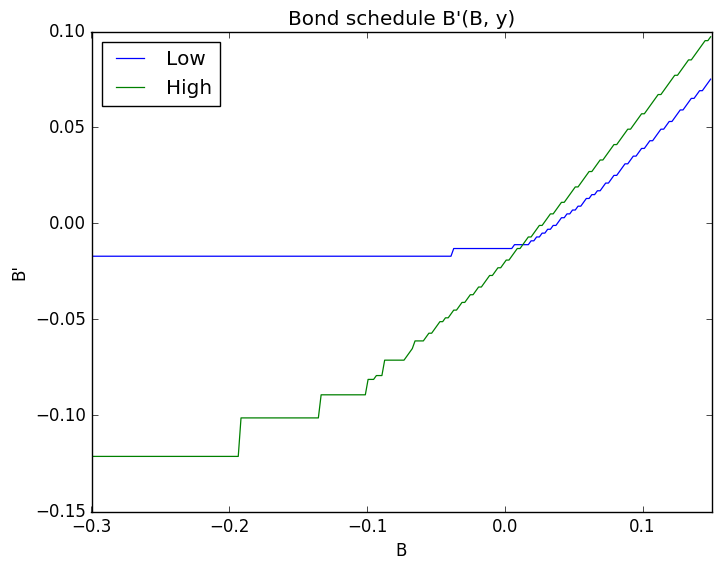

PyObject <matplotlib.text.Text object at 0x31ad72690>

In [6]:
# Bonds policy B'(B,y)

Bp = Array(Float64,ae.nB,ae.ns)

for nn=1:ae.ns
    Bp[:,nn] = ae.Bgrid[ae.policy[:,nn]]
end

# Extract a suitable plot grid
xb = Float64[]
bp_low = Float64[]
bp_high = Float64[]
for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.3 <= b <= 0.15  # To match fig 3 of Arellano
        push!(xb, b)
        push!(bp_low, Bp[i, iy_low])
        push!(bp_high, Bp[i, iy_high])
    end
end

vals_plot = [bp_low bp_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](xb,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Bond schedule B'(B, y)")
xlabel("B"); ylabel("B'")

Plot the value function

In [7]:
fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](ae.Bgrid,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Value functions")
xlabel("B"); ylabel("V(y,B)")

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError(u'x and y must have same first dimension',)
  File "/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/__init__.py", line 1812, in inner
    return func(ax, *args, **kwargs)
  File "/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_axes.py", line 1424, in plot
    for line in self._get_lines(*args, **kwargs):
  File "/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 386, in _grab_next_args
    for seg in self._plot_args(remaining, kwargs):
  File "/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 364, in _plot_args
    x, y = self._xy_from_xy(x, y)
  File "/Users/jmorelli/.julia/v0.4/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/axes/_base.py", line 223, in _xy_from_xy
    raise ValueError("x and y must have same first dimension")

while loading In[7], in expression starting on line 2

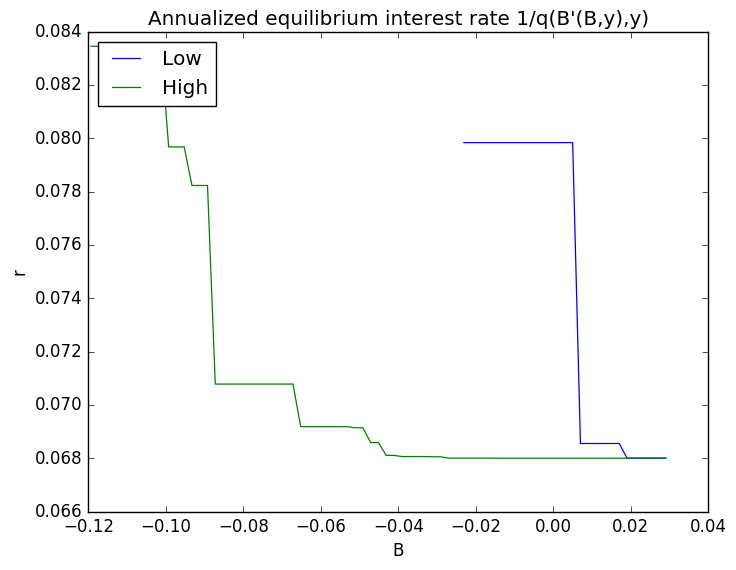

PyObject <matplotlib.text.Text object at 0x322f69a90>

In [8]:
# Interest Rates

# Extract a suitable plot grid
xr = Float64[]
r_low = Float64[]
r_high = Float64[]

for i=1:ae.nB
    b = ae.Bgrid[i]
    if -0.12 <= b <= 0.03
        push!(xr, b)
        if ae.vf[i,iy_low]==ae.vc[i,iy_low]
            push!(r_low, (1/ae.q[ae.policy[i,iy_low], iy_low]-1)*4)
        else
            push!(r_low, NaN)
        end
        if ae.vf[i,iy_high]==ae.vc[i,iy_high]
            push!(r_high, (1/ae.q[ae.policy[i,iy_high], iy_high]-1)*4)
        else
            push!(r_high, NaN)
        end
    end
end

vals_plot = [r_low r_high]

fig, ax = subplots()
for i in 1:2
    str_i = str[i]
    ax[:plot](xr,vals_plot[:,i], linewidth=0.9, label="$str_i", alpha=1)
end
ax[:legend](loc="upper left")
title("Annualized equilibrium interest rate 1/q(B'(B,y),y)")
xlabel("B"); ylabel("r")

### Simulation for Statistics

Nothing new here, except that we are going to simulate two processes now: $\Delta$ and $\epsilon$.

In [9]:
using StatsBase

Tsim = 50000

Δ_init = mean(ae.Δgrid)

ΠΔsum = similar(ae.ΠΔ)
cumsum!(ΠΔsum,ae.ΠΔ,2)
Δ_sim_ind  = Array(Int64,Tsim)
Δ_init_ind = searchsortedfirst(ae.Δgrid,Δ_init)
Δ_sim_ind[1] = Δ_init_ind
    
distrib = Uniform()   
random_numbers_Δ = rand(distrib,Tsim)   
    
for tt=2:Tsim
    Δ_ind = Δ_sim_ind[tt-1]
    prob  = ΠΔsum[Δ_ind,:]'[:,1]
    Δ_sim_ind[tt] = searchsortedfirst(prob, random_numbers_Δ[tt-1])
end

In [10]:
ϵ_init = mean(ae.ϵgrid)

Πϵsum = similar(ae.Πϵ)
cumsum!(Πϵsum,ae.Πϵ,2)
ϵ_sim_ind  = Array(Int64,Tsim)
ϵ_init_ind = searchsortedfirst(ae.ϵgrid,ϵ_init)
ϵ_sim_ind[1,:] = ϵ_init_ind
    
distrib = Uniform()   
random_numbers_ϵ = rand(distrib,Tsim)

y_sim_ind = Array(Int64,Tsim)

ne = length(ae.ϵgrid)

ϵ_val = ae.ϵgrid[ϵ_sim_ind[1]]
Δ_val = ae.Δgrid[Δ_sim_ind[1]]
y_val = exp(Δ_val+ϵ_val)
    
y_sim_ind[1] = findmin(abs(y_val-ae.ygrid))[2]
    
for tt=2:Tsim
    ϵ_ind = ϵ_sim_ind[tt-1]
    prob  = Πϵsum[ϵ_ind,:]'[:,1]
    ϵ_sim_ind[tt] = searchsortedfirst(prob, random_numbers_ϵ[tt-1])
        
#     y_sim_ind[tt] = (Δ_sim_ind[tt]-1)*ne + ϵ_sim_ind[tt]
    ϵ_val = ae.ϵgrid[ϵ_sim_ind[tt]]
    Δ_val = ae.Δgrid[Δ_sim_ind[tt]]
    y_val = exp(Δ_val+ϵ_val)
    
    y_sim_ind[tt] = findmin(abs(y_val-ae.ygrid))[2]
end

In [11]:
B_init = mean(ae.Bgrid)
zero_index = searchsortedfirst(ae.Bgrid, 0.)
B_init_ind = searchsortedfirst(ae.Bgrid, B_init)

y_sim_val = Array(Float64,Tsim)
q_sim_val, c_sim_val = similar(y_sim_val), similar(y_sim_val)

B_sim_val       = Array(Float64,Tsim+1)
B_sim_indices   = Array(Int64, Tsim+1)
default_status_sim  = fill(false, Tsim+1)

q_sim_def = []

B_sim_indices[1], default_status_sim[1] = B_init_ind, false
y_sim_val[1], B_sim_val[1] = ae.ygrid[y_sim_ind[1]], ae.Bgrid[B_init_ind]  

start_default = []
end_default = []
    
for t=1:Tsim
    # Get today's indexes
    yi, Bi = y_sim_ind[t], B_sim_indices[t]
    defstat = default_status_sim[t]

    # If you are not in default
    if !defstat
        default_today = ae.vc[Bi, yi] < ae.vd[yi] ? true: false

        if default_today
            # Default values
            default_status_sim[t] = true
            default_status_sim[t+1] = true
            y_sim_val[t] = ae.ydefgrid[y_sim_ind[t]]
            c_sim_val[t] = y_sim_val[t]
            B_sim_indices[t+1] = zero_index
            B_sim_val[t+1] = 0.
            q_sim_val[t] = ae.q[zero_index, y_sim_ind[t]]
            push!(q_sim_def,q_sim_val[t-1])
            push!(start_default,t)

            else
            default_status_sim[t] = false
            y_sim_val[t] = ae.ygrid[y_sim_ind[t]]
            B_sim_indices[t+1] = ae.policy[Bi, yi]
            B_sim_val[t+1] = ae.Bgrid[B_sim_indices[t+1]]
            q_sim_val[t]   = ae.q[B_sim_indices[t+1], y_sim_ind[t]]
            c_sim_val[t]   = y_sim_val[t] - q_sim_val[t]*B_sim_val[t+1]+B_sim_val[t]
                                    
            end

        # If you are in default
        else
        B_sim_indices[t+1] = zero_index
        B_sim_val[t+1] = 0.
        y_sim_val[t] = ae.ydefgrid[y_sim_ind[t]]
        c_sim_val[t] = y_sim_val[t]
        q_sim_val[t] = ae.q[zero_index, y_sim_ind[t]]

        # With probability θ exit default status
        if rand() < ae.θ
            default_status_sim[t+1] = false
            push!(end_default,t)
        else
            default_status_sim[t+1] = true
        end
    end
end

Plot the last 250 observations:

In [ ]:
# using Gadfly

# # find starting and ending periods of recessions (if any)
# if any(default_status_sim)
#     defs = find(default_status_sim)
#     def_breaks = diff(defs) .> 1
#     def_start = defs[[true; def_breaks]]
#     def_end = defs[[def_breaks; true]]
# else
#     starts, ends = Int[], Int[]
# end

# # construct boxes that shade periods of default
# def_box = Guide.annotation(compose(context(), 
#                                    [rectangle(i[1], 0h, i[2]-i[1], 1h) 
#                                     for i=zip(def_start, def_end)]...,
#                                   fill(RGBA(0.5, 0.5, 0.5, 0.2))))

# # xy labels are common for all plots
# xy_lab = [Guide.xlabel("time"), Guide.ylabel("")]

# # now iterate over three variables and put them into an array
# plots = Gadfly.Plot[]
# for (vec, name) in [(y_sim_val[end-249:end], "Output"), (B_sim_val[end-249:end], "Foreign assets"), (q_sim_val[end-249:end], "Bond price")]
#     push!(plots, 
#     plot(x=1:250, y=vec, Geom.line, def_box, Guide.title(name), xy_lab...))
# end

# # set final plot height and vertically stack the above three plots
# set_default_plot_size(6inch, 8inch)
# vstack(plots...)

Compute statistics as in Arellano (2008). Identify begining and ending of default events with pre-default history of 74 periods or more. Choose only the last 100 of them. This is following Arellano (2008) who takes the limiting distribution of assets.

In [12]:
default_probability = length(start_default)/(Tsim - sum(default_status_sim))*100

Tmax = 74 # time horizon for each sample, from Arellano (2008)

## Save only default episodes with previous history of at least Tmax periods

# Find first time that subsample is long enough and redefine vectors
ind_first     = findfirst(start_default.>=Tmax) 
start_default = start_default[ind_first:end]
end_default   = end_default[ind_first:end]

# Find distance between defaults and save only those subsamples long enough
diff_start_end = start_default[2:end] - end_default[1:end-1]
filter_sample  = find(diff_start_end.>=Tmax)

start_default_sample = [start_default[1];start_default[filter_sample + 1]]
end_default_sample   = [end_default[filter_sample];end_default[filter_sample[end]+1]];

# Get the last 100 default events
start_default_sample = start_default_sample[end-99:end]
end_default_sample   = end_default_sample[end-99:end];

Compute statistics for pre-default periods:

In [13]:
yvals_sim = Array(Float64,Tmax,length(start_default_sample))

bvals_sim,qvals_sim,cvals_sim,tbvals_sim,spread_sim = 
similar(yvals_sim),similar(yvals_sim),similar(yvals_sim),similar(yvals_sim),similar(yvals_sim)

corr_y_spread = Array(Float64,length(start_default_sample),1)

corr_y_tbalance,corr_y_consumption,corr_r_tbalance,corr_r_consumption = 
similar(corr_y_spread),similar(corr_y_spread),similar(corr_y_spread),similar(corr_y_spread)

# Statistics 74 periods previous to default

for ii=1:length(start_default_sample)
    init  = start_default_sample[ii]-Tmax
    final = start_default_sample[ii]-1
        
    yvals_sim[:,ii]  = y_sim_val[init:final]
    bvals_sim[:,ii]  = B_sim_val[init:final]./yvals_sim[:,ii]
    qvals_sim[:,ii]  = q_sim_val[init:final]
    cvals_sim[:,ii]  = c_sim_val[init:final]
    tbvals_sim[:,ii] = (yvals_sim[:,ii] - cvals_sim[:,ii])./yvals_sim[:,ii]
    spread_sim[:,ii] = (1./q_sim_val[init:final] - ae.r - 1)
    
    corr_y_spread[ii]      = cov(spread_sim[:,ii],yvals_sim[:,ii])/(std(spread_sim[:,ii])*std(yvals_sim[:,ii]))
    corr_y_tbalance[ii]    = cov(tbvals_sim[:,ii],yvals_sim[:,ii])/(std(tbvals_sim[:,ii])*std(yvals_sim[:,ii]))
    corr_y_consumption[ii] = cov(cvals_sim[:,ii],yvals_sim[:,ii])/(std(cvals_sim[:,ii])*std(yvals_sim[:,ii]))
    
    corr_r_tbalance[ii]    = cov(tbvals_sim[:,ii],spread_sim[:,ii])/(std(tbvals_sim[:,ii])*std(spread_sim[:,ii]))
    corr_r_consumption[ii] = cov(cvals_sim[:,ii],spread_sim[:,ii])/(std(cvals_sim[:,ii])*std(spread_sim[:,ii]))
end

mean_spread   = mean(spread_sim)*400
mean_tbalance = mean(tbvals_sim)*100
mean_debt_y   = -mean(bvals_sim)*100

mean_consumption = mean(cvals_sim)
mean_output      = mean(yvals_sim)

std_spread       = mean(std(spread_sim,1))*400
std_tbalance     = mean(std(tbvals_sim,1))*100
std_consumption  = mean(std(cvals_sim,1))*100
std_output       = mean(std(yvals_sim,1))*100

corr_y_spread      = mean(corr_y_spread)
corr_y_tbalance    = mean(corr_y_tbalance)
corr_y_consumption = mean(corr_y_consumption)
corr_r_tbalance    = mean(corr_r_tbalance)
corr_r_consumption = mean(corr_r_consumption);

Compute moments for Default Episodes as in Table 4 of Arellano (2008).
Consumption, output and trade balance deviations are measured with respect to the pre-default periods' mean.
Interest rates spread is measured at one period before declaring default.

In [14]:
## Statistics in period previous to default

spread_default_episode   = (1./q_sim_val[start_default_sample-1] - ae.r - 1)

mean_spread_default_episode   = mean(spread_default_episode)*400


mean_consumption_default_episode = mean(c_sim_val[start_default_sample-1])
fall_consumption = mean((mean(cvals_sim,1)'[:,1] - c_sim_val[start_default_sample-1])./(mean(cvals_sim,1)'[:,1]))*100

mean_output_default_episode = mean(y_sim_val[start_default_sample-1])
fall_output = mean((mean(yvals_sim,1)'[:,1] - y_sim_val[start_default_sample-1])./(mean(yvals_sim,1)'[:,1]))*100

tbalance_default_episode = mean((c_sim_val[start_default_sample-1] - 
y_sim_val[start_default_sample-1])/y_sim_val[start_default_sample-1])

tbalance_pre_default     = (mean((yvals_sim-cvals_sim)./yvals_sim,1)'[:,1])
tbalance_default_episode = (y_sim_val[start_default_sample-1] - c_sim_val[start_default_sample-1])./y_sim_val[start_default_sample-1]

variation_tbalance_episode = mean(tbalance_default_episode - tbalance_pre_default)*100


# Standard Deviations
std_spread_default_episode       = mean(std(spread_default_episode,1))*400
std_tbalance_default_episode     = mean(std(tbalance_default_episode,1))
std_consumption_default_episode  = mean(std(c_sim_val[start_default_sample-1],1))*100
std_output_default_episode       = mean(std(y_sim_val[start_default_sample-1],1))*100


# Correlations with output
corr_spread_y_default_episode = cov(spread_default_episode,y_sim_val[start_default_sample-1])/
(std(spread_default_episode)*std(y_sim_val[start_default_sample-1]))

corr_tbalance_y_default_episode = cov(tbalance_default_episode,y_sim_val[start_default_sample-1])/
(std(tbalance_default_episode)*std(y_sim_val[start_default_sample-1]))

corr_consumption_y_default_episode = cov(c_sim_val[start_default_sample-1],y_sim_val[start_default_sample-1])/
(std(c_sim_val[start_default_sample-1])*std(y_sim_val[start_default_sample-1]))

# Correlations with Spreads
corr_tbalance_r_default_episode = cov(tbalance_default_episode,spread_default_episode)/
(std(tbalance_default_episode)*std(spread_default_episode))

corr_consumption_r_default = cov(c_sim_val[start_default_sample-1],spread_default_episode)/
(std(c_sim_val[start_default_sample-1])*std(spread_default_episode));

In [15]:
## Variables during default

yvals_sim_default = Array{Float64}[]

for ii=1:length(start_default_sample)
    init  = start_default_sample[ii]
    final = end_default_sample[ii]
        
    push!(yvals_sim_default,y_sim_val[init:final])
end


# Compute moments

mean_y_default = Float64[]

for ii=1:length(start_default_sample)
    y = yvals_sim_default[ii]
    push!(mean_y_default,mean(y))

end

mean_y_default = mean(mean_y_default)

deviation_output = (mean_y_default/mean_output - 1)*100;

In [16]:
println("Numbers for Table 4 from Arellano (2008)")
println("For one period before default")
println("Default Episodes - Interest rate spread: $(mean_spread_default_episode)")
println("Default Episodes - Trade Balance: $(variation_tbalance_episode)")
println("Default Episodes - Fall Consumption (positive = fall): $(fall_consumption)")
println("Default Episodes - Fall Output (positive = fall): $(fall_output)")
println(" ")
println("Standard Deviation - Interest rate spread: $(std_spread)")
println("Standard Deviation - Trade Balance: $(std_tbalance)")
println("Standard Deviation - Consumption: $(std_consumption)")
println("Standard Deviation - Output: $(std_output)")
println(" ")
println("Correlation Y - Interest rate spread: $(corr_y_spread)")
println("Correlation Y - Trade Balance: $(corr_y_tbalance)")
println("Correlation Y - Consumption: $(corr_y_consumption)")
println(" ")
println("Correlation R - Trade Balance: $(corr_r_tbalance)")
println("Correlation R - Consumption: $(corr_r_consumption)")
println(" ")
println(" ")
println("Other statistics - Samples excluding defaults")
println("Mean Debt (percent output): $(mean_debt_y)")
println("Mean Spread: $(mean_spread)")
println("Output deviation in default: $(deviation_output)")
println("Probability of Default: $(default_probability)")


Numbers for Table 4 from Arellano (2008)
For one period before default
Default Episodes - Interest rate spread: 2.5593472193786644
Default Episodes - Trade Balance: 0.1812652121035016
Default Episodes - Fall Consumption (positive = fall): 2.02091131070693
Default Episodes - Fall Output (positive = fall): 1.8413480155459965
 
Standard Deviation - Interest rate spread: 1.192827720928135
Standard Deviation - Trade Balance: 0.4827120904106092
Standard Deviation - Consumption: 2.8932862758523448
Standard Deviation - Output: 2.7195956929956373
 
Correlation Y - Interest rate spread: -0.6019221342859483
Correlation Y - Trade Balance: -0.2880501124662775
Correlation Y - Consumption: 0.9869870407969521
 
Correlation R - Trade Balance: 0.25194577038086946
Correlation R - Consumption: -0.6077158162968938
 
 
Other statistics - Samples excluding defaults
Mean Debt (percent output): 3.031376002267211
Mean Spread: 1.2302294424032543
Output deviation in default: -4.6972609765183915
Probability of Def

### Simulation for Panel Regression

In what follows we will simulate for N countries, compute Arellano (2008) statistics, save the simulated data on output and spreads for 53 countries and then run the same panel regressions as for the empirical data, but for the country fixed effects.

First simulate the common systemic component $\Delta_{t}$. We compute for a sufficiently large time horizon but then we will extract the last T = 84 periods, as to get the limiting distribution.

In [17]:
using StatsBase

T = 4*21 # Arellano has data from 1980 to 2001

Tpanel = 1000

Δ_init = mean(ae.Δgrid)

ΠΔsum = similar(ae.ΠΔ)
cumsum!(ΠΔsum,ae.ΠΔ,2)
Δ_panel_ind  = Array(Int64,Tpanel)
Δ_init_ind = searchsortedfirst(ae.Δgrid,Δ_init)
Δ_panel_ind[1] = Δ_init_ind
    
distrib = Uniform()   
random_numbers = rand(distrib,Tpanel)   
    
for tt=2:Tpanel
    Δ_ind = Δ_panel_ind[tt-1]
    prob  = ΠΔsum[Δ_ind,:]'[:,1]
    Δ_panel_ind[tt] = searchsortedfirst(prob, random_numbers[tt-1])
end

Run the simulations for the idiosyncratic component for the N countries. Compute simulated output indices matrix.

In [18]:
NN = 5000

ϵ_init = mean(ae.ϵgrid)

Πϵsum = similar(ae.Πϵ)
cumsum!(Πϵsum,ae.Πϵ,2)
ϵ_panel_ind  = Array(Int64,Tpanel,NN)
ϵ_init_ind = searchsortedfirst(ae.ϵgrid,ϵ_init)
ϵ_panel_ind[1,:] = ϵ_init_ind*ones(1,NN)
    
distrib = Uniform()   
random_numbers = rand(distrib,Tpanel,NN)

y_panel_ind = Array(Int64,Tpanel,NN)

ne = length(ae.ϵgrid)

for nn=1:NN
    
    y_panel_ind[1,nn] = (Δ_panel_ind[1]-1)*ne + ϵ_panel_ind[1,nn]
    
    for tt=2:Tpanel
        ϵ_ind = ϵ_panel_ind[tt-1,nn]
        prob  = Πϵsum[ϵ_ind,:]'[:,1]
        ϵ_panel_ind[tt,nn] = searchsortedfirst(prob, random_numbers[tt-1,nn])
        
        y_panel_ind[tt,nn] = (Δ_panel_ind[tt]-1)*ne + ϵ_panel_ind[tt,nn]
    end
end

Run the simulation for the rest of the variables.

Note: 

     To save the initial dates for default we are using push!() and saving as array of arrays. Perhaps it is quicker to save in cells instead. Try to find some way to preallocate memory and increase speed.

In [19]:
B_init=mean(ae.Bgrid)
zero_index = searchsortedfirst(ae.Bgrid, 0.)
B_init_ind = searchsortedfirst(ae.Bgrid, B_init)

y_panel_val = Array(Float64,Tpanel,NN)
q_panel_val, c_panel_val = similar(y_panel_val), similar(y_panel_val)

B_panel_val = Array(Float64,Tpanel+1,NN)
B_panel_indices = Array(Int64, Tpanel+1,NN)
default_status  = fill(false, Tpanel+1,NN)

q_panel_def     = []
start_panel_def = []
default_index   = []

periods = 100

for nn=1:NN
    B_panel_indices[1,nn], default_status[1,nn] = B_init_ind, false
    y_panel_val[1,nn], B_panel_val[1,nn] = ae.ygrid[y_panel_ind[1,nn]], ae.Bgrid[B_init_ind]
    q_def = []
    start_def = []
    
    for t=1:Tpanel
        # Get today's indexes
        yi, Bi = y_panel_ind[t,nn], B_panel_indices[t,nn]
        defstat = default_status[t,nn]

        # If you are not in default
        if !defstat
            default_today = ae.vc[Bi, yi] < ae.vd[yi] ? true: false

            if default_today
                # Default values
                default_status[t,nn] = true
                default_status[t+1,nn] = true
                y_panel_val[t,nn] = ae.ydefgrid[y_panel_ind[t,nn]]
                c_panel_val[t,nn] = y_panel_val[t,nn]
                B_panel_indices[t+1,nn] = zero_index
                B_panel_val[t+1,nn] = 0.
                q_panel_val[t,nn] = ae.q[zero_index, y_panel_ind[t,nn]]
                
                if t>=(Tpanel-periods+1)
                    push!(q_def,q_panel_val[t-1,nn])
                    push!(start_def,t)
                    push!(default_index,1)
                end

            else
                default_status[t,nn] = false
                y_panel_val[t,nn] = ae.ygrid[y_panel_ind[t,nn]]
                B_panel_indices[t+1,nn] = ae.policy[Bi, yi]
                B_panel_val[t+1,nn] = ae.Bgrid[B_panel_indices[t+1,nn]]
                q_panel_val[t,nn]   = ae.q[B_panel_indices[t+1,nn], y_panel_ind[t,nn]]
                c_panel_val[t,nn]   = y_panel_val[t,nn] - q_panel_val[t,nn]*B_panel_val[t+1,nn]+B_panel_val[t,nn]
                                    
            end

        # If you are in default
        else
            B_panel_indices[t+1,nn] = zero_index
            B_panel_val[t+1,nn] = 0.
            y_panel_val[t,nn] = ae.ydefgrid[y_panel_ind[t,nn]]
            c_panel_val[t,nn] = y_panel_val[t,nn]
            q_panel_val[t,nn] = ae.q[zero_index, y_panel_ind[t,nn]]

            # With probability θ exit default status
            if rand() < ae.θ
                default_status[t+1,nn] = false
            else
                default_status[t+1,nn] = true
            end
        end
    end
    push!(q_panel_def,q_def)
    push!(start_panel_def,start_def)
end

Take the last T = 84 observations for 53 countries on output and spreads:

In [20]:
output_out  = y_panel_val[end-T+1:end,1:53]
spreads_out = (1./q_panel_val[end-T+1:end,1:53] - ae.r - 1.0)*40000;